# Exploration into D*-Lite in simulated 3D terrain
The purpose of this notebook is to explore the D* Lite algorithm and its performance as compared to A* when path-planning in 3D terrain. The initial path planning will be done on coarse estimated 3D terrain and updated as more fine detail is learned about the terrain.

### Autoreload modules
**ALWAYS RUN THIS DURING DEVELOPMENT.**

Run this cell to make sure that modules are automatically reloaded as changes are made and the kernel does not need to be restarted.

In [1]:
%load_ext autoreload
%autoreload 2

## Tasks
These are the following steps that have been and still need to be completed:
- [x] Creating random terrain 
  - [x] Terrain should have varying levels of resolution, scale, and detail
  - [x] Terrain should be generated at coarse and fine levels of detail
- [x] Creating a grid map
  - [x] Discretize each x,y,z point of map into nodes
  - [x] Map the successors, predecessors, and edges connected to each node
  - [x] Create a container which can house all nodes
- [x] Implementing A*
  - [x] Write A* algorithm using grid map and edge costs
  - [x] Assign start and goal and create path 
  - [x] Display A* path (nodes travelled) on terrain map
- [x] Implementing D*-Lite
  - [x] Updating edge costs to grid map
  - [x] Rescan ability to grid map
  - [x] Write D*-Lite algorithm using grid map and edge costs
  - [x] Assign start and goal and create path
  - [x] Display D*-Lite path and recalculated path (nodes travelled) on terrain map
- [ ] Compare methods
  - [ ] Create quantititave performance analysis of computation time, cost of path
  - [ ] A* computed on fine terrain and performed on fine terrain (Baseline)
  - [ ] A* computed on coarse terrain and performed on fine terrain (Current approach)
  - [ ] A* computed on coarse terrain and performed on fine terrain with recalculating on update (Next approach) 
  - [ ] D*-Lite computed on coarse terrain and performed on fine terrain (Proposed approach)
- [ ] Possible simulation improvements
  - [ ] Add large obstacles to terrain
  - [ ] Adding enemy sightline simulation
  - [ ] Make simulated terrain non-square

## Creating Terrain
The first step is to create simulated terrain. A common technique to create random terrain is to use specific kinds of noises that create terrain-like shapes. In this example, we use simplex noise, one of the most commonly used typs of noise for generation of terrain.

### Import and Setup
Setup Jupyter Notebook with all important settings. 

To make graphic maps interactable, change
`%matplotlib inline` 
to
`%matplotlib qt`

In [2]:
%matplotlib inline
import noise
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from random import randrange
import time

### Setup terrain hyperparameters
The noise consists of a different hyperparameters:
- resolution: How many "pixels" are used to represent terrain. *NOT* the coarseness or fineness of the map detail.
- scale: How large an area is being mapped (e.g `scale = 1.5` mean each "pixel"/node represents a 1.5x1.5 area).
- octaves: The level of detail of the terrain. Used to simulate coarse (small amount of octaves) and fine (large amount of octaves) detail of the terrain. An increase by 3 octaves from coarse to fine seems to result in the best looking terrain.
- random_seed: If random_seed is True, the offset is randomly chosen. If False, offset is set to 0. Python noise generation methods are not random and the same offset will produce the same results.
- min_height and max_height: The coarse map is scaled so the lowest point of the map is min_height and the highest point is max_height. The fine map is scaled to the coarse map to preserve the original relationship betwewn the values of the two maps.


In [3]:
resolution = 200
scale = 2.0
coarse_octaves = 1
fine_octaves = 4
random_seed = False
min_height = 0.0
max_height = 100.0

### Create terrain

The noise is generated according to the parameters as defined above.

In [4]:
if random_seed:
    offset = randrange(100)
else:
    offset = 0

shape = (resolution, resolution)
rough_world = np.zeros(shape)
fine_world = np.zeros(shape)

for i in range(resolution):
    for j in range(resolution):
        rough_world[i][j] = noise.snoise2(i*scale/resolution, 
                                    j*scale/resolution, 
                                    octaves=coarse_octaves,  
                                    base=offset)
        fine_world[i][j] = noise.snoise2(i*scale/resolution, 
                                    j*scale/resolution, 
                                    octaves=fine_octaves, 
                                    base=offset)

The noise is then scaled to min and max height to create terrain.

In [5]:
fine_world = (fine_world-np.min(rough_world)) / (np.max(rough_world)-np.min(rough_world)) #scale fine world according to coarse world
fine_world = min_height + (max_height-min_height) * fine_world

rough_world = (rough_world-np.min(rough_world)) / (np.max(rough_world)-np.min(rough_world)) #scale coarse world between 0.0 and 1.0
rough_world = min_height + (max_height-min_height) * rough_world

### Display Terrain
We now display the terrain both as 2D bird'eye views of the terrain and 3D views of the terrain.
#### Bird's Eye View

Text(0.5, 1.0, 'Fine Terrain Detail')

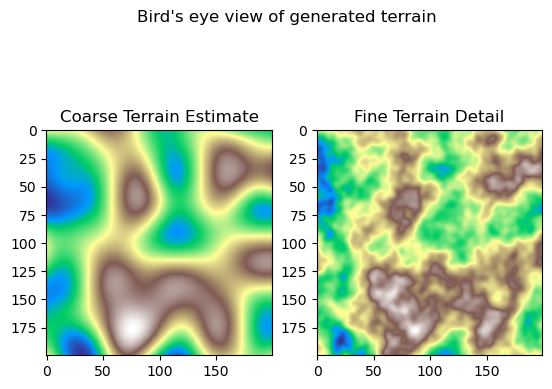

In [6]:
fig_t_be, axs = plt.subplots(1,2)
fig_t_be.suptitle("Bird's eye view of generated terrain")
axs[0].imshow(rough_world,cmap='terrain')
axs[0].set_title('Coarse Terrain Estimate')             
axs[1].imshow(fine_world,cmap='terrain')
axs[1].set_title('Fine Terrain Detail')    

#### 3D View of Terrain

Text(0.5, 0.92, 'Fine Terrain Detail')

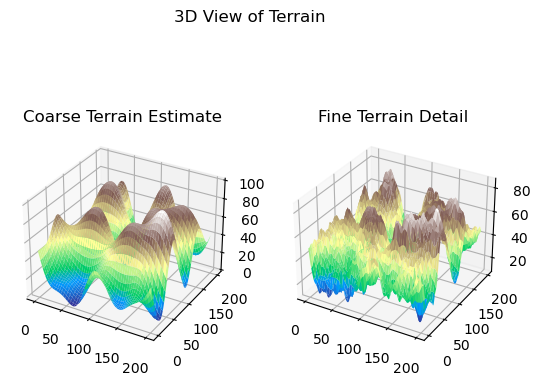

In [7]:
lin_x = np.linspace(0,resolution,resolution,endpoint=False)
lin_y = np.linspace(0,resolution,resolution,endpoint=False)
x,y = np.meshgrid(lin_x,lin_y)

fig_t_3d = plt.figure()
fig_t_3d.suptitle("3D View of Terrain")
ax_rough = fig_t_3d.add_subplot(121, projection="3d")
ax_rough.plot_surface(y,x,rough_world,cmap='terrain')
ax_rough.set_title('Coarse Terrain Estimate')

ax_fine = fig_t_3d.add_subplot(122, projection="3d")
ax_fine.plot_surface(y,x,fine_world,cmap='terrain')
ax_fine.set_title('Fine Terrain Detail')

## Creating Grid Map
This section is implemented in `src/utils.py` and `src/grid.py`

In [8]:
from src.grid import Grid

rough_grid = Grid(rough_world)
fine_grid = Grid(fine_world)

## A* Path Planning
### Baseline A* (No Updates)
This section is implemented in the AStar class in `src/astar.py`.
Planners are initialized with terrain array and then paths are retrieved from point to point using `get_path(position1, position2)`.
The path is returned as a list of positions but can be given as a numpy array of x,y,z positions. 

In [9]:
from src.astar import AStar

curr_map = fine_world

pathplanner_base = AStar(curr_map)

Time execution of path and calculate cost of path on the fine grid.

In [10]:
start = time.perf_counter()
path_baseline = pathplanner_base.get_path((10,10), (resolution-10,resolution-10))
end = time.perf_counter()

elapsed_base = end - start
cost_base = fine_grid.calc_path_cost(path_baseline)

print(f"AStarBaseline path cost = {cost_base} in {elapsed_base} sec")

AStarBaseline path cost = 340.4586686648907 in 0.4950603999895975 sec


Plot path on the terrain, both bird's eye view and 3D view.

Text(0.5, 0.92, 'Terrain with Path')

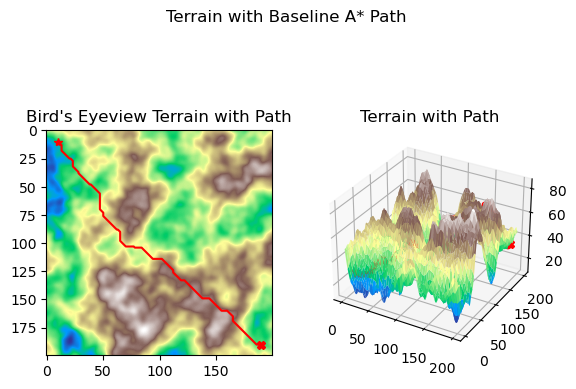

In [11]:
arr_baseline = fine_grid.path_to_np(path_baseline)

xx_baseline = arr_baseline[0, :]
yy_baseline = arr_baseline[1, :]
zz_baseline = arr_baseline[2, :]

fig_as = plt.figure()
fig_as.suptitle("Terrain with Baseline A* Path")

ax = fig_as.add_subplot(121)
ax.imshow(curr_map,cmap='terrain')
ax.plot(yy_baseline,xx_baseline, 'r')
ax.plot(yy_baseline[0],xx_baseline[0],'r*')
ax.plot(yy_baseline[-1],xx_baseline[-1],'rX')
ax.set_title("Bird's Eyeview Terrain with Path")

ax3 = fig_as.add_subplot(122, projection='3d')
ax3.plot_surface(y,x,curr_map,cmap='terrain')
ax3.plot(xx_baseline,yy_baseline,zz_baseline,'r.')
ax3.plot(xx_baseline[0],yy_baseline[0],zz_baseline[0],'r*')
ax3.plot(xx_baseline[-1],yy_baseline[-1],zz_baseline[-1],'rX')
ax3.set_title('Terrain with Path')

### Naive A* Pathplanning
The first approach to planning in partially unknown environments is to simply path plan in the known environemnt and execute that path in the true world without updating based on new information.

In [12]:
pathplanner_naive = AStar(rough_world)


start = time.perf_counter()
path_naive = pathplanner_naive.get_path((10,10), (resolution-10,resolution-10))
end = time.perf_counter()

elapsed_naive = end - start
cost_naive = fine_grid.calc_path_cost(path_naive)

print(f"AStarNaive path cost = {cost_naive} in {elapsed_naive} sec")

AStarNaive path cost = 415.1530189177408 in 0.39363359997514635 sec


Plot naive path from Bird's Eye View and 3D view

Text(0.5, 0.92, 'Terrain with Path')

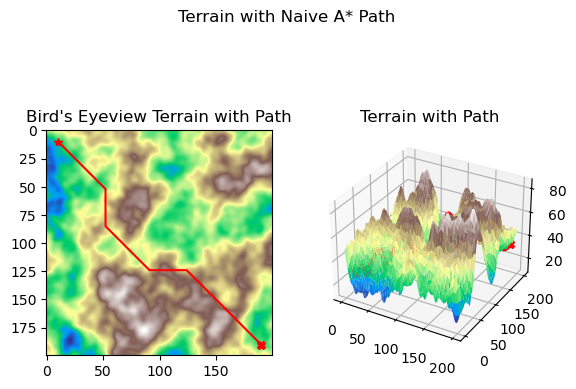

In [13]:
arr_naive = fine_grid.path_to_np(path_naive)

xx_naive = arr_naive[0, :]
yy_naive = arr_naive[1, :]
zz_naive = arr_naive[2, :]

fig_asn = plt.figure()
fig_asn.suptitle("Terrain with Naive A* Path")

ax = fig_asn.add_subplot(121)
ax.imshow(curr_map,cmap='terrain')
ax.plot(yy_naive,xx_naive, 'r')
ax.plot(yy_naive[0],xx_naive[0],'r*')
ax.plot(yy_naive[-1],xx_naive[-1],'rX')
ax.set_title("Bird's Eyeview Terrain with Path")

ax3 = fig_asn.add_subplot(122, projection='3d')
ax3.plot_surface(y,x,curr_map,cmap='terrain')
ax3.plot(xx_naive,yy_naive,zz_naive,'r.')
ax3.plot(xx_naive[0],yy_naive[0],zz_naive[0],'r*')
ax3.plot(xx_naive[-1],yy_naive[-1],zz_naive[-1],'rX')
ax3.set_title('Terrain with Path')

### A* With Updates
This section is implemented in the AStarUpdate class in `src/astar.py`. It is used in the same way as the AStar planner except it is initialized with a known terrain array which represents the known information that path planning is done on and a ground truth terrain that updates the known map as rescanning is done.

- update_step: How many steps/scans intervals should the path be recalculated. Set to 0 for recalclation to not occur based on interval (default = 1)
- scan_radius: How many nodes around the current node are updated in a single scan (default = 1) 
- err_threshold: How much accumulated error/difference should there be between known grid and true grid before path is recalculated. Set to infinity if never updated based on error (default = math.inf)

In [14]:
from src.astar import AStarUpdate

known_map = rough_world
true_map = fine_world

update_step = 1
scan_radius = 10
err_threshold = math.inf

asu_planner = AStarUpdate(known_map, true_map, update_step, scan_radius, err_threshold)

Get path as numpy arrays AFTER calculating path.

In [15]:
start = time.perf_counter()
path_asu = asu_planner.get_path((10,10), (resolution-10,resolution-10))
end = time.perf_counter()

elapsed_asu = end - start
cost_asu = fine_grid.calc_path_cost(path_asu)

print(f"AStarUpdate path cost = {cost_asu} in {elapsed_asu} sec")

AStarUpdate path cost = 363.7879694142968 in 36.029949599993415 sec


Plot path on the terrain, both bird's eye view and 3D view.

Text(0.5, 0.92, 'Terrain with Path')

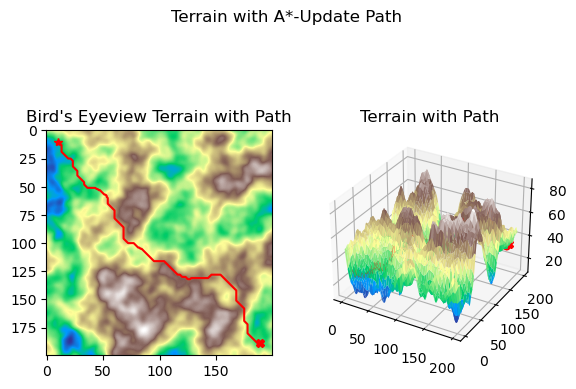

In [16]:
arr_asu = asu_planner.get_plt_arrays()

xx_asu = arr_asu[0, :]
yy_asu = arr_asu[1, :]
zz_asu = arr_asu[2, :]

fig_asu = plt.figure()
fig_asu.suptitle("Terrain with A*-Update Path")

ax = fig_asu.add_subplot(121)
ax.imshow(true_map,cmap='terrain')
ax.plot(yy_asu,xx_asu, 'r')
ax.plot(yy_asu[0],xx_asu[0],'r*')
ax.plot(yy_asu[-1],xx_asu[-1],'rX')
ax.set_title("Bird's Eyeview Terrain with Path")

ax3 = fig_asu.add_subplot(122, projection='3d')
ax3.plot_surface(y,x,true_map,cmap='terrain')
ax3.plot(xx_asu,yy_asu,zz_asu,'r.')
ax3.plot(xx_asu[0],yy_asu[0],zz_asu[0],'r*')
ax3.plot(xx_asu[-1],yy_asu[-1],zz_asu[-1],'rX')
ax3.set_title('Terrain with Path')

Display original map planning was done on, the final map with the updated information, and the ground truth map.

Text(0.5, 1.0, 'Ground truth map')

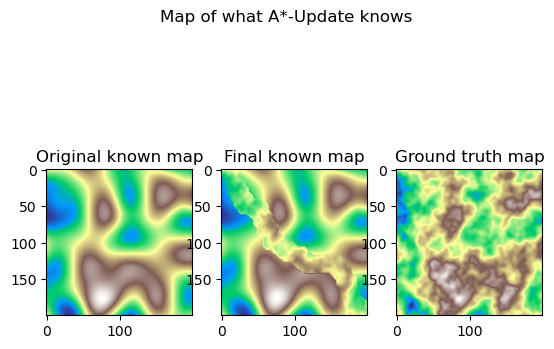

In [17]:
final_known_terrain = asu_planner.known_grid.to_np()

fig_learn = plt.figure()
fig_learn.suptitle("Map of what A*-Update knows")
ax1 = fig_learn.add_subplot(131)
ax1.imshow(known_map, cmap='terrain')
ax1.set_title("Original known map")
ax2 = fig_learn.add_subplot(132)
ax2.imshow(final_known_terrain, cmap='terrain')
ax2.set_title("Final known map")
ax3 = fig_learn.add_subplot(133)
ax3.imshow(true_map, cmap='terrain')
ax3.set_title("Ground truth map")

## D*-Lite Pathplanning
This section is implemented in `src/dsl.py`. It is used in the same way as the AStarUpdate planner with the same parameters.

In [18]:
from src.dsl import DStarLite

known_map = rough_world
true_map = fine_world

update_step = 1
scan_radius = 10
err_threshold = math.inf

dsl_planner = DStarLite(known_map, true_map, update_step, scan_radius, err_threshold)

Get path as numpy arrays AFTER calculating path.

In [19]:
start = time.perf_counter()
path_dsl = dsl_planner.get_path((10,10), (resolution-10,resolution-10))
end = time.perf_counter()

elapsed_dsl = end - start
cost_dsl = fine_grid.calc_path_cost(path_dsl)

print(f"DStarLite path cost = {cost_dsl} in {elapsed_dsl} sec")

DStarLite path cost = 365.28755765258586 in 2.9152645000140183 sec


Plot path on the terrain, both bird's eye view and 3D view.

Text(0.5, 0.92, 'Terrain with Path')

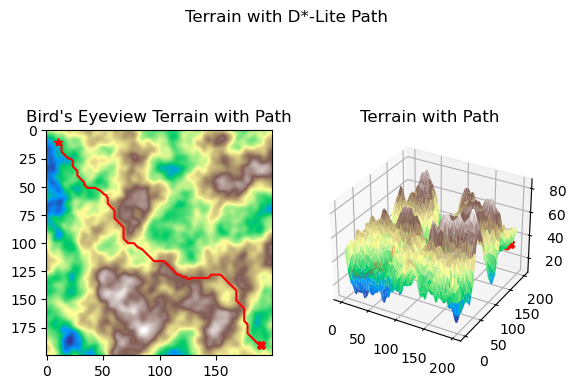

In [20]:
arr_dsl = dsl_planner.get_plt_arrays()

xx_dsl = arr_dsl[0, :]
yy_dsl = arr_dsl[1, :]
zz_dsl = arr_dsl[2, :]

fig_dsl = plt.figure()
fig_dsl.suptitle("Terrain with D*-Lite Path")

ax = fig_dsl.add_subplot(121)
ax.imshow(true_map,cmap='terrain')
ax.plot(yy_dsl,xx_dsl, 'r')
ax.plot(yy_dsl[0],xx_dsl[0],'r*')
ax.plot(yy_dsl[-1],xx_dsl[-1],'rX')
ax.set_title("Bird's Eyeview Terrain with Path")

ax3 = fig_dsl.add_subplot(122, projection='3d')
ax3.plot_surface(y,x,true_map,cmap='terrain')
ax3.plot(xx_dsl,yy_dsl,zz_dsl,'r.')
ax3.plot(xx_dsl[0],yy_dsl[0],zz_dsl[0],'r*')
ax3.plot(xx_dsl[-1],yy_dsl[-1],zz_dsl[-1],'rX')
ax3.set_title('Terrain with Path')

Display original map planning was done on, the final map with the updated information, and the ground truth map.

Text(0.5, 1.0, 'Ground truth map')

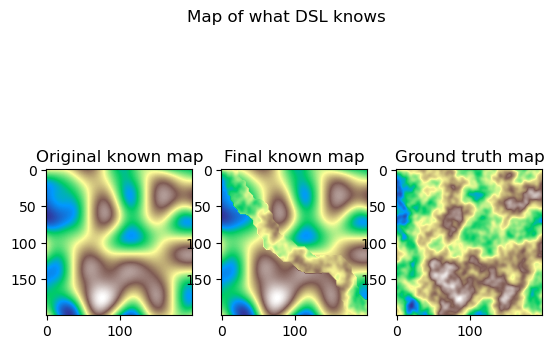

In [21]:
final_known_terrain = dsl_planner.known_grid.to_np()

fig_learn = plt.figure()
fig_learn.suptitle("Map of what DSL knows")
ax1 = fig_learn.add_subplot(131)
ax1.imshow(known_map, cmap='terrain')
ax1.set_title("Original known map")
ax2 = fig_learn.add_subplot(132)
ax2.imshow(final_known_terrain, cmap='terrain')
ax2.set_title("Final known map")
ax3 = fig_learn.add_subplot(133)
ax3.imshow(true_map, cmap='terrain')
ax3.set_title("Ground truth map")